Cleaning

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Load dataset
cafe_df = pd.read_csv(r"C:\Users\Sharon\Desktop\dirty_cafe_sales.csv")

# Step 1: Replace known error tokens with NaN for several columns
error_values = ['ERROR', 'UNKNOWN', 'unknown']
cols_to_clean = ['Item', 'Quantity', 'Price Per Unit', 'Total Spent', 'Payment Method', 'Location', 'Transaction Date']
cafe_df[cols_to_clean] = cafe_df[cols_to_clean].replace(error_values, np.nan)n)


In [13]:
# Step 2: Convert numerical and date columns
cafe_df['Quantity'] = pd.to_numeric(cafe_df['Quantity'], errors='coerce')
cafe_df['Price Per Unit'] = pd.to_numeric(cafe_df['Price Per Unit'], errors='coerce')
cafe_df['Total Spent'] = pd.to_numeric(cafe_df['Total Spent'], errors='coerce')
cafe_df['Transaction Date'] = pd.to_datetime(cafe_df['Transaction Date'], errors='coerce')

In [14]:
# Step 3: Impute missing values based on relationships between Quantity, Price Per Unit, and Total Spent
mask_q = cafe_df['Quantity'].isna() & cafe_df['Total Spent'].notna() & cafe_df['Price Per Unit'].notna()
cafe_df.loc[mask_q, 'Quantity'] = cafe_df.loc[mask_q, 'Total Spent'] / cafe_df.loc[mask_q, 'Price Per Unit']

mask_p = cafe_df['Price Per Unit'].isna() & cafe_df['Total Spent'].notna() & cafe_df['Quantity'].notna()
cafe_df.loc[mask_p, 'Price Per Unit'] = cafe_df.loc[mask_p, 'Total Spent'] / cafe_df.loc[mask_p, 'Quantity']

mask_t = cafe_df['Total Spent'].isna() & cafe_df['Quantity'].notna() & cafe_df['Price Per Unit'].notna()
cafe_df.loc[mask_t, 'Total Spent'] = cafe_df.loc[mask_t, 'Quantity'] * cafe_df.loc[mask_t, 'Price Per Unit']

In [15]:
# Step 4: Infer missing Price Per Unit from Item name
def infer_price(row):
    price_map = {
        'Salad': 5,
        'Juice': 3,
        'Sandwich': 4,
        'Coffee': 2,
        'Tea': 1.5,
        'Cake': 3,
        'Smoothie': 4,
        'Cookie': 1
    }
    item = row['Item']
    price = row['Price Per Unit']
    return price_map.get(item, price)

cafe_df['Price Per Unit'] = cafe_df.apply(infer_price, axis=1)


In [16]:
# Step 5: Infer Item name if Price Per Unit is unique and Item is unknown
def infer_item(row):
    reverse_map = {
        5: 'Salad',
        3: 'Juice',
        4: 'Sandwich',
        2: 'Coffee',
        1.5: 'Tea',
        1: 'Cookie'
    }
    item = row['Item']
    price = row['Price Per Unit']
    if pd.isna(item) or item.lower() == 'unknown':
        return reverse_map.get(price, np.nan)
    return item

cafe_df['Item'] = cafe_df.apply(infer_item, axis=1)

In [55]:
# Step 6: For Payment Method
cafe_df['Payment Method'] = cafe_df['Payment Method'].replace(['ERROR', 'UNKNOWN', 'unknown', 'Unknown', np.nan], 'Digital Wallet')
cafe_df['Payment Method'] = cafe_df['Payment Method'].fillna('Digital Wallet')

In [67]:
cafe_df['Location'] = cafe_df['Location'].fillna('Takeaway')

In [68]:
# (Optional) Additional cleaning for Item:
# Replace missing or unknown items with an inferred value if possible.
# Here we simply fill missing items with "Unknown" for clarity.
cafe_df['Item'] = cafe_df['Item'].fillna('Unknown')

# Optional: Drop rows missing critical numerical data after imputation
cafe_df.dropna(subset=['Quantity', 'Price Per Unit', 'Total Spent'], inplace=True)

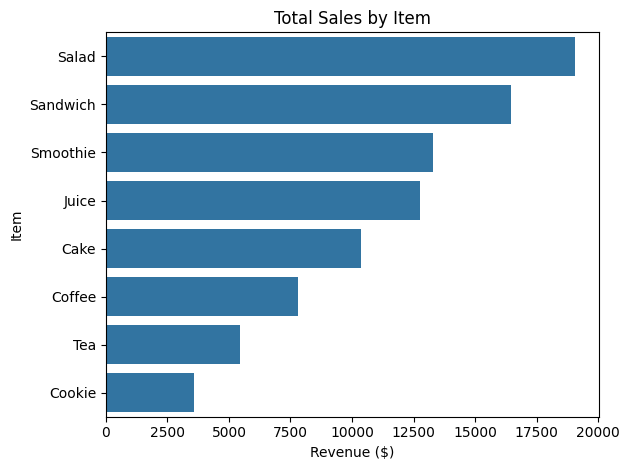

In [69]:
item_sales = cafe_df.groupby('Item')['Total Spent'].sum().sort_values(ascending=False).reset_index()
sns.barplot(data=item_sales, x='Total Spent', y='Item')
plt.title('Total Sales by Item')
plt.xlabel('Revenue ($)')
plt.ylabel('Item')
plt.tight_layout()
plt.show()

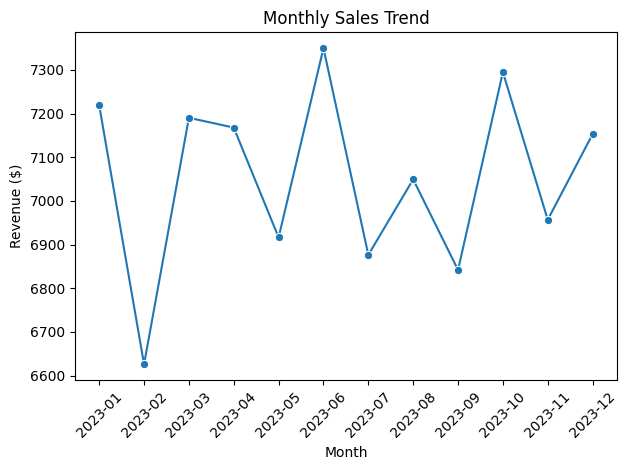

In [72]:
cafe_df['Month'] = cafe_df['Transaction Date'].dt.to_period('M')
monthly_sales = cafe_df.groupby('Month')['Total Spent'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].astype(str)
sns.lineplot(data=monthly_sales, x='Month', y='Total Spent', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

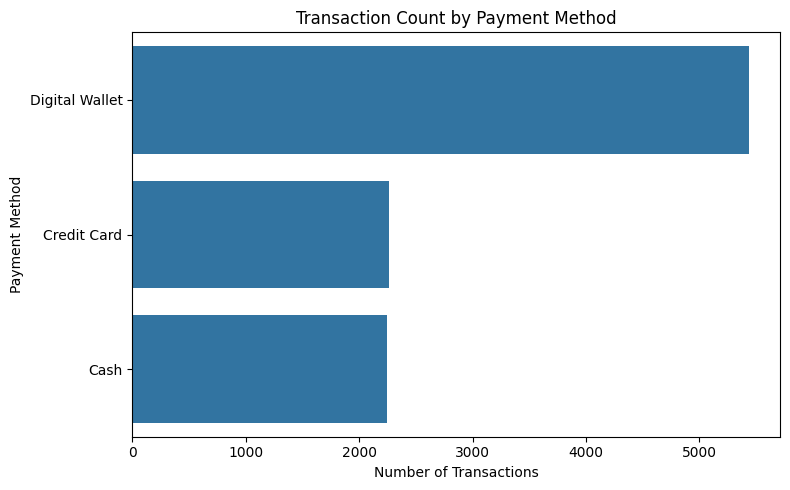

In [73]:
# 1. Bar Chart: Transaction Count by Payment Method
plt.figure(figsize=(8, 5))
payment_counts = cafe_df['Payment Method'].value_counts().reset_index()
payment_counts.columns = ['Payment Method', 'Count']

sns.barplot(data=payment_counts, x='Count', y='Payment Method')
plt.title('Transaction Count by Payment Method')
plt.xlabel('Number of Transactions')
plt.ylabel('Payment Method')
plt.tight_layout()
plt.show()

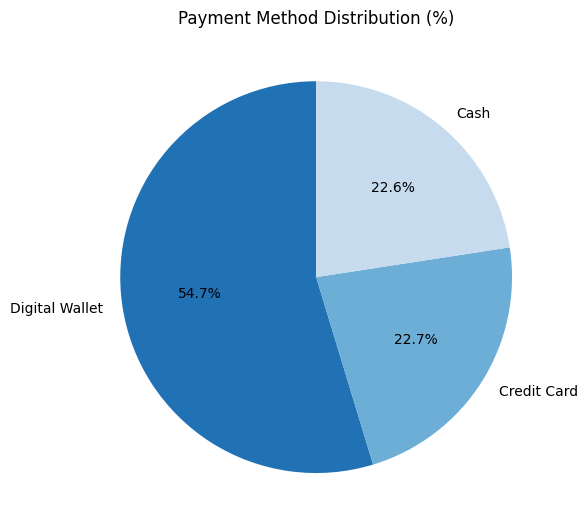

In [74]:

# 2. Pie Chart: Payment Method Distribution
plt.figure(figsize=(6, 6))
# Use .value_counts() directly; since we filled missing as 'Unknown', these appear as another slice.
cafe_df['Payment Method'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Blues_r', n_colors=len(cafe_df['Payment Method'].value_counts()))
)
plt.title('Payment Method Distribution (%)')
plt.ylabel('')  # Remove y-axis label for clarity
plt.tight_layout()
plt.show()

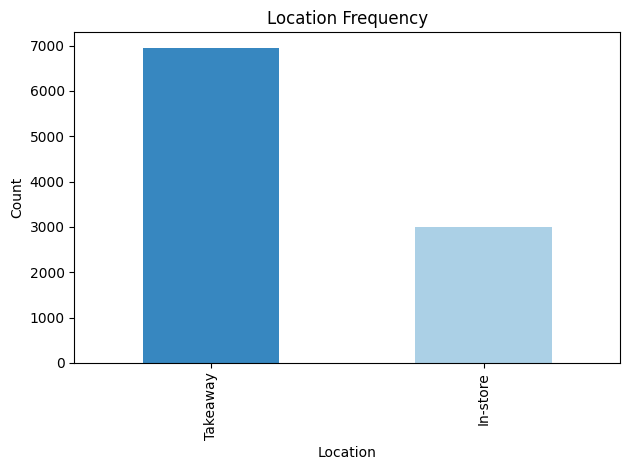

In [75]:
colors = sns.color_palette('Blues_r', n_colors=2)
# Bar Chart
cafe_df['Location'].value_counts().plot(kind='bar', color=colors)
plt.title('Location Frequency')
plt.xlabel('Location')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

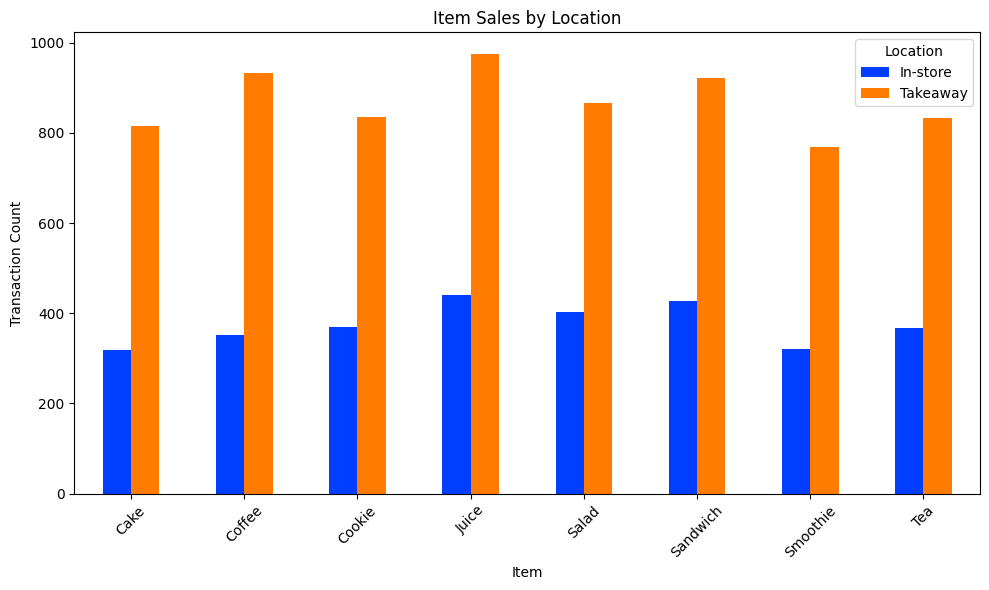

In [78]:
sns.set_palette("bright")

pd.crosstab(cafe_df['Item'], cafe_df['Location']).plot(
    kind='bar',
    figsize=(10, 6)
)
plt.title('Item Sales by Location')
plt.xlabel('Item')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

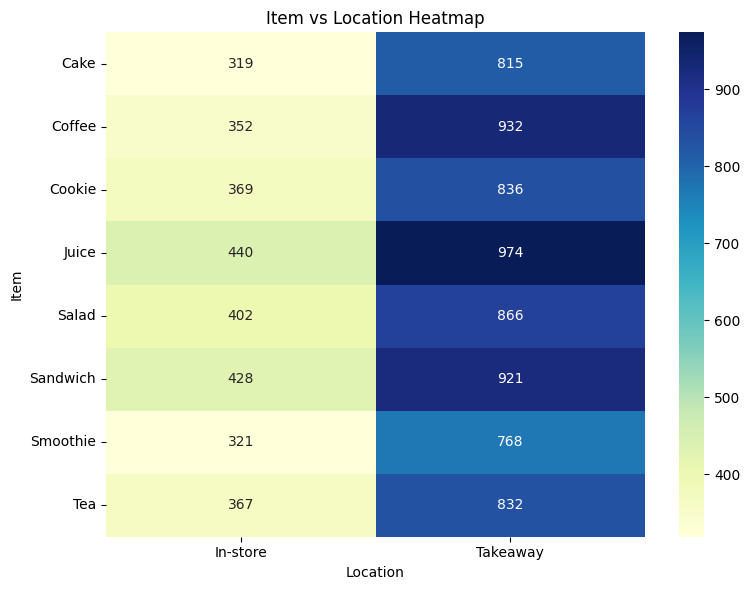

In [79]:
# Create the crosstab
heatmap_data = pd.crosstab(cafe_df['Item'], cafe_df['Location'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Item vs Location Heatmap')
plt.xlabel('Location')
plt.ylabel('Item')
plt.tight_layout()
plt.show()

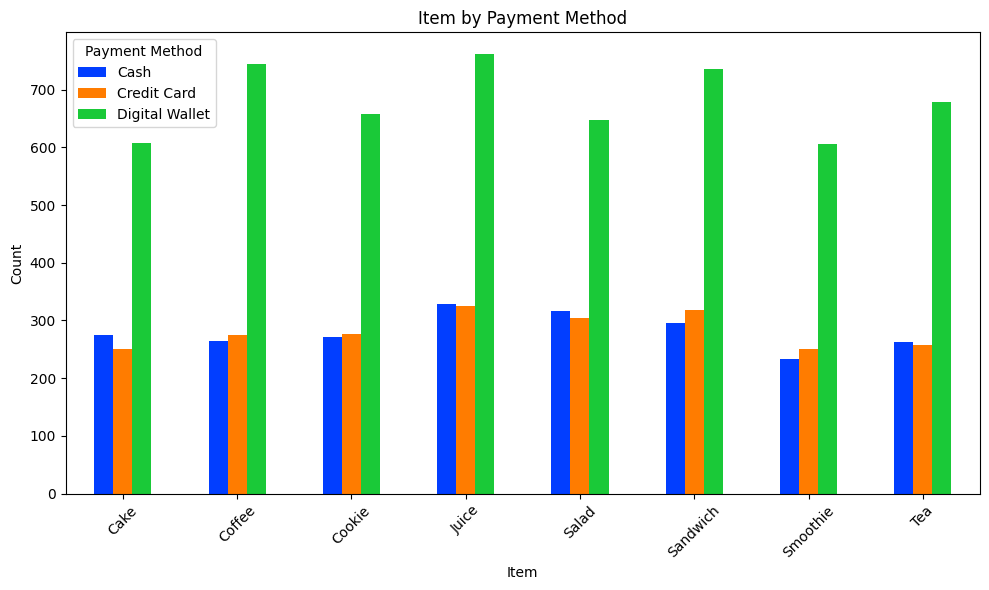

In [80]:
# Crosstab for Item vs Payment Method
crosstab_pm = pd.crosstab(cafe_df['Item'], cafe_df['Payment Method'])

# Plot
crosstab_pm.plot(kind='bar', figsize=(10, 6))
plt.title('Item by Payment Method')
plt.xlabel('Item')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()